In [1]:
import pandas as pd
import random
import numpy as np

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score

from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [2]:
#построение графика
def barplot(x_data, y_data, error_data, x_label="", y_label="", title=""):
    fig, ax = plt.subplots(figsize = (17,17))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.errorbar(x_data, y_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    fig.savefig(title + '.png')
    
    plt.show()

In [3]:
# построение матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, savef = False, cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if savef:
        fig.savefig(title + '.png')
    plt.show()
    return ax

In [28]:
#обучение и проверка классификатора
def learn_test_classifier(x_train, y_train, x_test, y_test, classifier):
    classifier.fit(x_train, y_train)
    res = classifier.predict(x_test)

    print('hamming_loss: ', hamming_loss(y_test, res))
    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))
    print('accuracy_score: ', accuracy_score(y_test, res))
    print('precision_score: ', precision_score(y_test, res, average='macro'))
    print('recall_score: ', recall_score(y_test, res, average='macro'))
    print('f1_score: ', f1_score(y_test, res, average='macro'))
    
    return res

#прогон кластера
def start_clustering(data, y_test, cluster):
    cluster.fit(data)
    res = cluster.labels_

    print('accuracy_score: ', accuracy_score(y_test, res))
    print('hamming_loss: ', hamming_loss(y_test, res))
    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))
    print('precision_score: ', precision_score(y_test, res, average='macro'))
    print('recall_score: ', recall_score(y_test, res, average='macro'))
    print('f1_score: ', f1_score(y_test, res, average='macro'))
    print('completeness_score: ', completeness_score(y_test, res))
    print('adjusted_rand_score: ', adjusted_rand_score(y_test, res))
    print('v_measure_score: ', v_measure_score(y_test, res))
    
    return res

Загрузка данных

In [4]:
data = pd.read_csv('Data/training_set.csv', nrows = 10000)
data.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [5]:
data_m = pd.read_csv('Data/training_set_metadata.csv', nrows = 60)

data_m.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [6]:
print(data_m.loc[len(data_m) - 1])

object_id             10757.000000
ra                       52.910156
decl                    -26.276812
gal_l                   220.926149
gal_b                   -54.363918
ddf                       1.000000
hostgal_specz             0.169900
hostgal_photoz            0.171100
hostgal_photoz_err        0.018500
distmod                  39.580100
mwebv                     0.008000
target                   52.000000
Name: 59, dtype: float64


In [7]:
data = data.merge(data_m,on='object_id')
data.head()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [8]:
#корреляция признаков
data.corr()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
object_id,1.000000,-0.070063,0.010212,0.091103,-0.026175,0.042718,0.013186,0.065784,0.112827,0.116478,NaN,-0.021644,0.045471,-0.000749,-0.078529,-0.116326,-0.203492
mjd,-0.070063,1.000000,-0.061066,0.044465,0.008791,0.064973,-0.004087,-0.119036,0.043410,-0.205297,NaN,0.010451,0.016281,-0.057078,0.015609,-0.075325,0.007406
passband,0.010212,-0.061066,1.000000,0.035137,0.439607,0.008139,0.010236,0.020313,-0.007648,0.052042,NaN,0.004171,-0.005300,0.006255,-0.001400,0.024544,0.000923
flux,0.091103,0.044465,0.035137,1.000000,-0.013020,0.015747,0.026832,0.039002,-0.032552,0.040781,NaN,0.002837,0.010220,0.076424,-0.088304,0.052435,-0.080902
flux_err,-0.026175,0.008791,0.439607,-0.013020,1.000000,-0.019570,0.044546,-0.018121,0.013468,0.044273,NaN,-0.051267,-0.057373,-0.041326,-0.008511,0.040634,0.002162
detected,0.042718,0.064973,0.008139,0.015747,-0.019570,1.000000,-0.091759,-0.031842,0.060741,-0.012819,NaN,-0.039254,-0.096990,-0.039115,-0.016700,-0.098412,0.106571
ra,0.013186,-0.004087,0.010236,0.026832,0.044546,-0.091759,1.000000,-0.575778,0.520798,-0.060181,NaN,0.006431,-0.040442,-0.153533,-0.158210,0.353870,0.041176
decl,0.065784,-0.119036,0.020313,0.039002,-0.018121,-0.031842,-0.575778,1.000000,-0.844319,0.657976,NaN,0.000577,-0.029021,0.079931,0.028313,0.112070,-0.119531
gal_l,0.112827,0.043410,-0.007648,-0.032552,0.013468,0.060741,0.520798,-0.844319,1.000000,-0.416108,NaN,-0.079738,0.127069,0.148104,-0.013076,-0.310581,0.071040
gal_b,0.116478,-0.205297,0.052042,0.040781,0.044273,-0.012819,-0.060181,0.657976,-0.416108,1.000000,NaN,0.073116,-0.085622,0.043542,-0.001544,0.412194,0.010039


Предобработка

In [9]:
y = data['object_id']
data = data.drop(['target', 'object_id', 'mwebv', 'distmod', 'ddf', 'detected'], 1)

In [10]:
#в зависимости от эксперимента можно удалить и следующие признкаки
data = data.drop(['mjd', 'passband'], 1)

In [11]:
data.head()

,flux,flux_err,ra,decl,gal_l,gal_b,hostgal_specz,hostgal_photoz,hostgal_photoz_err
0,-544.810303,3.622952,349.046051,-61.943836,320.79653,-51.753706,0.0,0.0,0.0
1,-816.434326,5.553370,349.046051,-61.943836,320.79653,-51.753706,0.0,0.0,0.0
2,-471.385529,3.801213,349.046051,-61.943836,320.79653,-51.753706,0.0,0.0,0.0
3,-388.984985,11.395031,349.046051,-61.943836,320.79653,-51.753706,0.0,0.0,0.0
4,-681.858887,4.041204,349.046051,-61.943836,320.79653,-51.753706,0.0,0.0,0.0


In [12]:
for i in range(0, len(data['ra'])):
    data.iloc[i]['ra'] += random.uniform(-0.35, 0.65)
    data.iloc[i]['decl'] += random.uniform(-0.35, 0.65)
    data.iloc[i]['gal_l'] += random.uniform(-0.35, 0.65)
    data.iloc[i]['gal_b'] += random.uniform(-0.35, 0.65)
data.head()

,flux,flux_err,ra,decl,gal_l,gal_b,hostgal_specz,hostgal_photoz,hostgal_photoz_err
0,-544.810303,3.622952,349.372555,-62.166232,321.135479,-51.892594,0.0,0.0,0.0
1,-816.434326,5.553370,349.593085,-61.399246,320.677801,-51.553253,0.0,0.0,0.0
2,-471.385529,3.801213,349.626394,-61.827064,321.251285,-51.287559,0.0,0.0,0.0
3,-388.984985,11.395031,348.782037,-61.972747,320.558083,-51.837764,0.0,0.0,0.0
4,-681.858887,4.041204,349.624203,-61.358986,320.859313,-51.358633,0.0,0.0,0.0


In [13]:
for i in range(0, len(data['ra'])):
    data.iloc[i]['hostgal_specz'] += random.uniform(-0.02, 0.056)
    data.iloc[i]['hostgal_photoz'] += random.uniform(-0.02, 0.056)
    data.iloc[i]['hostgal_photoz_err'] += random.uniform(-0.02, 0.056)

In [14]:
data.head()

,flux,flux_err,ra,decl,gal_l,gal_b,hostgal_specz,hostgal_photoz,hostgal_photoz_err
0,-544.810303,3.622952,349.372555,-62.166232,321.135479,-51.892594,0.001934,0.042321,0.009062
1,-816.434326,5.553370,349.593085,-61.399246,320.677801,-51.553253,0.029875,0.054598,0.006732
2,-471.385529,3.801213,349.626394,-61.827064,321.251285,-51.287559,-0.018656,0.054869,0.008728
3,-388.984985,11.395031,348.782037,-61.972747,320.558083,-51.837764,0.044614,0.050625,0.018938
4,-681.858887,4.041204,349.624203,-61.358986,320.859313,-51.358633,-0.018055,-0.013455,-0.006950


In [15]:
#переименовываем классы
z = [] 
for i in y.drop_duplicates():
    z.append(i)
print(z)

def f(x, z):
     return int(z.index(x))

y_type = y.apply(lambda x: f(x, z))

[615, 713, 730, 745, 1124, 1227, 1598, 1632, 1920, 1926, 2072, 2103, 2300, 2330, 2624, 2677, 2922, 3041, 3285, 3423, 3489, 3910, 4088, 4132, 4171, 4173, 4220, 4389, 4595, 4819, 5527]


In [16]:
print(len(data))
print(len(z))

10000
31


31


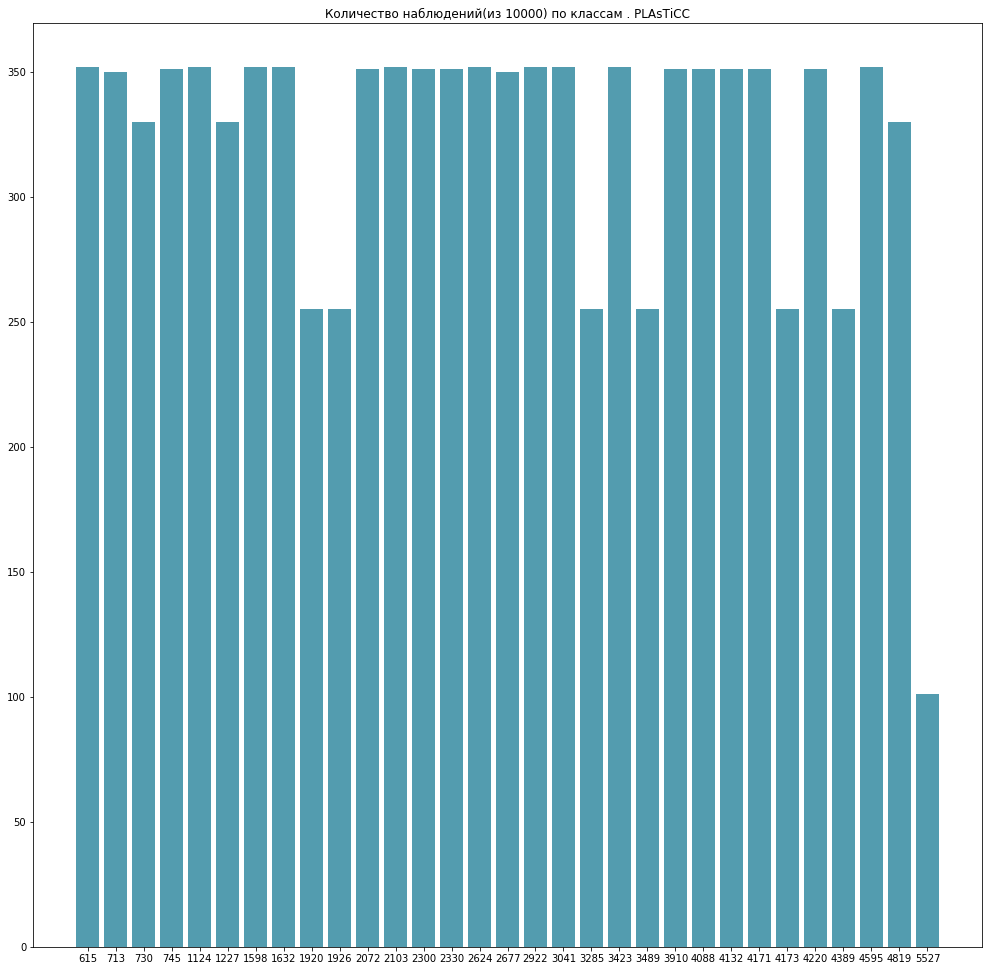

In [25]:
#рассмотрим распределение классов по кол-ву наблюдений
k = len(y_type.drop_duplicates())
print(k)

num_obs = [0 for i in range(0, k)]


for i in y:
    c = num_obs.pop(z.index(i))
    num_obs.insert(z.index(i), c + 1)


x_lab = [str(item) for item in z]

barplot(x_lab, num_obs, '', '', '', 'Количество наблюдений(из 10000) по классам . PLAsTiCC')

In [30]:
#делим данные на обучающий и тестовый набор
#в данном примере test_size = 0.8, эксперименты проводились и для test_size = 0.3, 0.7, как описано в статье
#на них же и подбиралась часть параметров
X_train, X_test, y_train, y_test = train_test_split(data, y_type, test_size=0.8, random_state=22, )

In [31]:
# шаблон для провеления десятикратных тестов (для подбора параметров; можно усреднять результаты/не выводить их):
'''
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(data):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svc = SVC(kernel='rbf', max_iter = 60, verbose = True)
    svc.fit(X_train, y_train)
    res = svc.predict(X_test)
    print('accuracy_score: ', accuracy_score(y_test, res))
    print('hamming_loss: ', hamming_loss(y_test, res))
    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))
    print('precision_score: ', precision_score(y_test, res, average='macro'))
    print('recall_score: ', recall_score(y_test, res, average='macro'))
    print('f1_score: ', f1_score(y_test, res, average='macro'))
    print()'''

"from sklearn.model_selection import KFold\ncv = KFold(n_splits=10, random_state=42, shuffle=True)\nfor train_index, test_index in cv.split(data):\n    X_train, X_test = data.iloc[train_index], data.iloc[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    svc = SVC(kernel='rbf', max_iter = 60, verbose = True)\n    svc.fit(X_train, y_train)\n    res = svc.predict(X_test)\n    print('accuracy_score: ', accuracy_score(y_test, res))\n    print('hamming_loss: ', hamming_loss(y_test, res))\n    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))\n    print('precision_score: ', precision_score(y_test, res, average='macro'))\n    print('recall_score: ', recall_score(y_test, res, average='macro'))\n    print('f1_score: ', f1_score(y_test, res, average='macro'))\n    print()"

In [33]:
print('knn: ')
knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', leaf_size=30)
knn_res = learn_test_classifier(X_train, y_train, X_test, y_test, knn)
print()

print('dt:')
dt = DecisionTreeClassifier()
dt_res = learn_test_classifier(X_train, y_train, X_test, y_test, dt)
print()

print('rf:')
rf = RandomForestClassifier(criterion = 'entropy')
rf_res = learn_test_classifier(X_train, y_train, X_test, y_test, rf)
print()

print('svc: ')
svc = SVC(kernel='rbf', max_iter = 60, verbose = True)
svc_res = learn_test_classifier(X_train, y_train, X_test, y_test, svc)
print()

print('xgb: ')
xgbM = xgb.XGBClassifier()
xgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, xgbM)
print()

print('lgb: ')
lgbM = lgb.LGBMClassifier(n_estimators=200, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27, objective = 'multiclass')
lgb_res = learn_test_classifier(X_train1, y_train1, X_test1, y_test1, lgbM)
print()

print('mlp: ')
m = len(X_train.columns)
p = len(y_train.drop_duplicates())
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*50,), verbose = False, tol = 0.0001)
mlp_res = learn_test_classifier(X_train, y_train, X_test, y_test, mlp)
print() 

knn: 
hamming_loss:  0.1265
matthews_corrcoef:  0.8692594178621416
accuracy_score:  0.8735
precision_score:  0.8653326862395044
recall_score:  0.8598424179255606
f1_score:  0.8606107258606708

dt:
hamming_loss:  0.000375
matthews_corrcoef:  0.9996121348699539
accuracy_score:  0.999625
precision_score:  0.9995559652570093
recall_score:  0.9993067371282326
f1_score:  0.9994296301460304

rf:
hamming_loss:  0.0
matthews_corrcoef:  1.0
accuracy_score:  1.0
precision_score:  1.0
recall_score:  1.0
f1_score:  1.0

svc: 
[LibSVM]

C:\Users\админ\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=60).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.653
matthews_corrcoef:  0.3469503325452444
accuracy_score:  0.347
precision_score:  0.307895351313898
recall_score:  0.33899490976079716
f1_score:  0.256248907345591

xgb: 


C:\Users\админ\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hamming_loss:  0.00275
matthews_corrcoef:  0.9971563355906993
accuracy_score:  0.99725
precision_score:  0.9973707880848908
recall_score:  0.9972697068916221
f1_score:  0.9973082327301149

lgb: 
hamming_loss:  0.00125
matthews_corrcoef:  0.9987071884149249
accuracy_score:  0.99875
precision_score:  0.9986514777798373
recall_score:  0.9986415669872721
f1_score:  0.9986440950974338

mlp: 
hamming_loss:  0.4455
matthews_corrcoef:  0.5535822309280425
accuracy_score:  0.5545
precision_score:  0.5258547171278218
recall_score:  0.5434454929361772
f1_score:  0.48806992671158467



C:\Users\админ\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


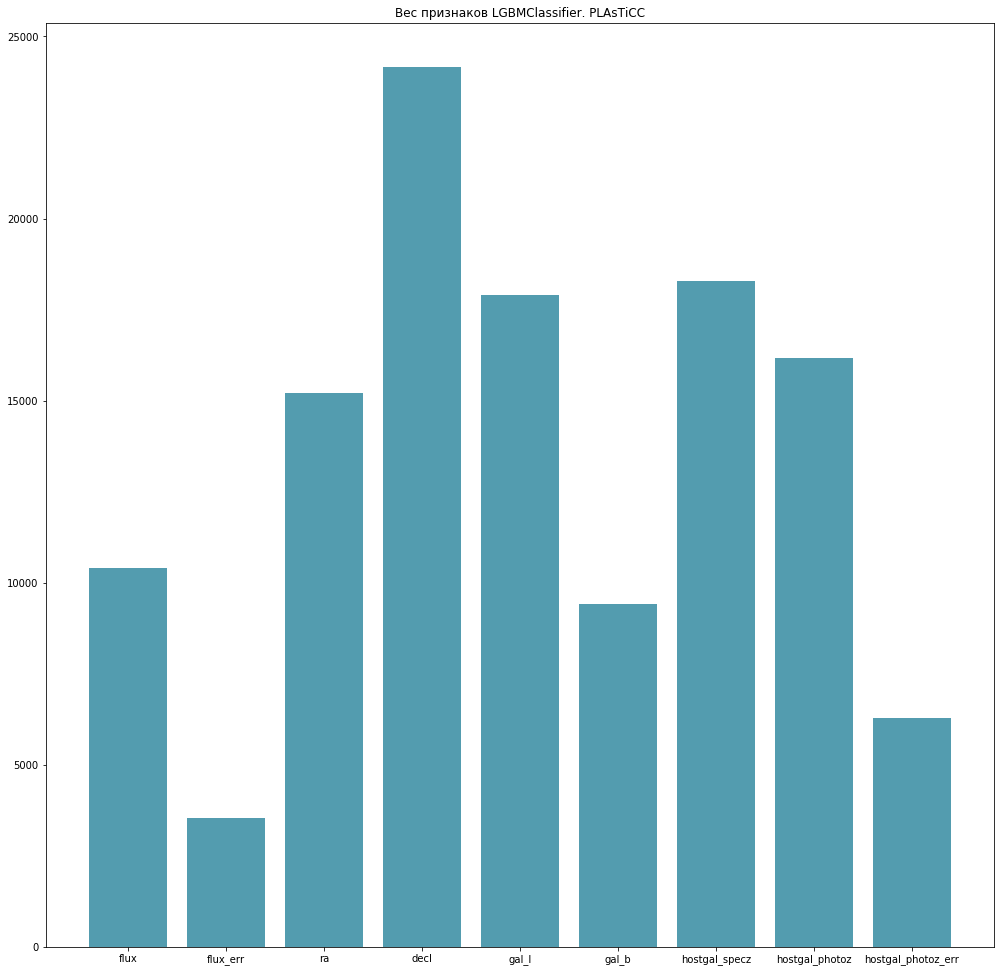

In [35]:
weight_f = lgbM.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков LGBMClassifier. PLAsTiCC')

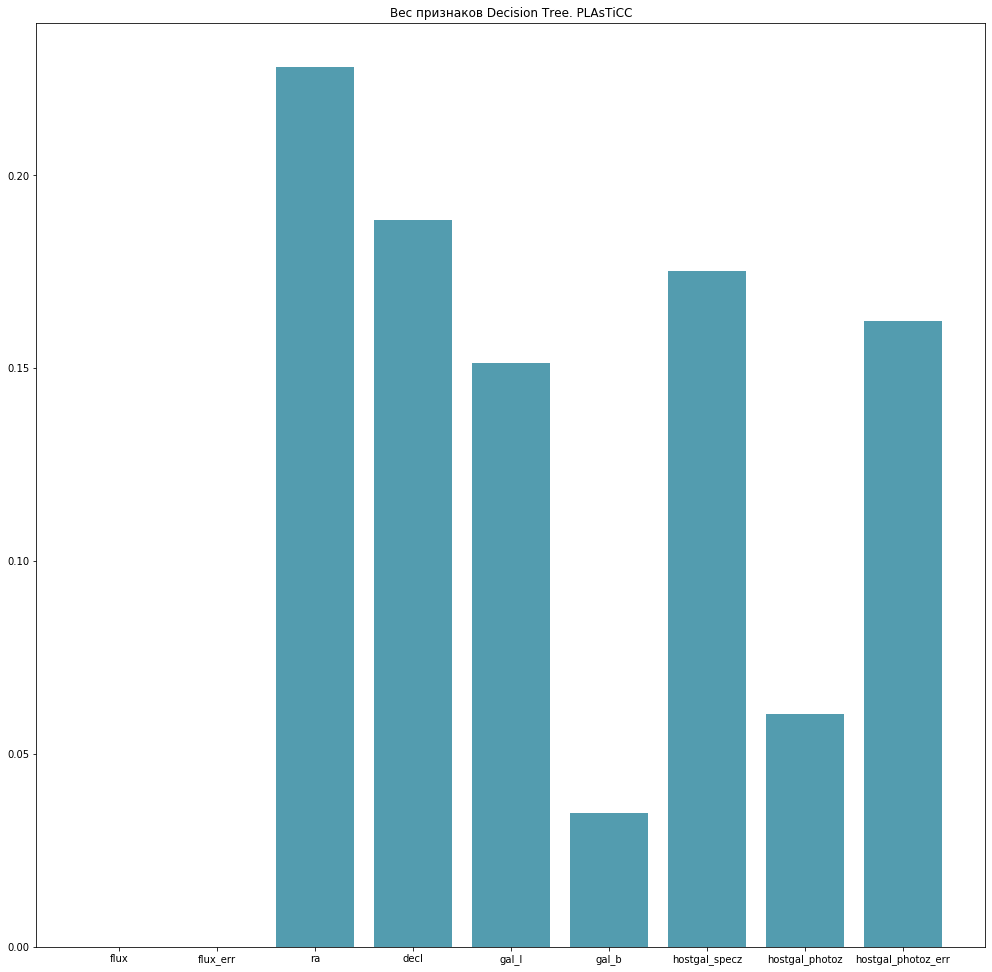

In [37]:
weight_f = dt.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree. PLAsTiCC')

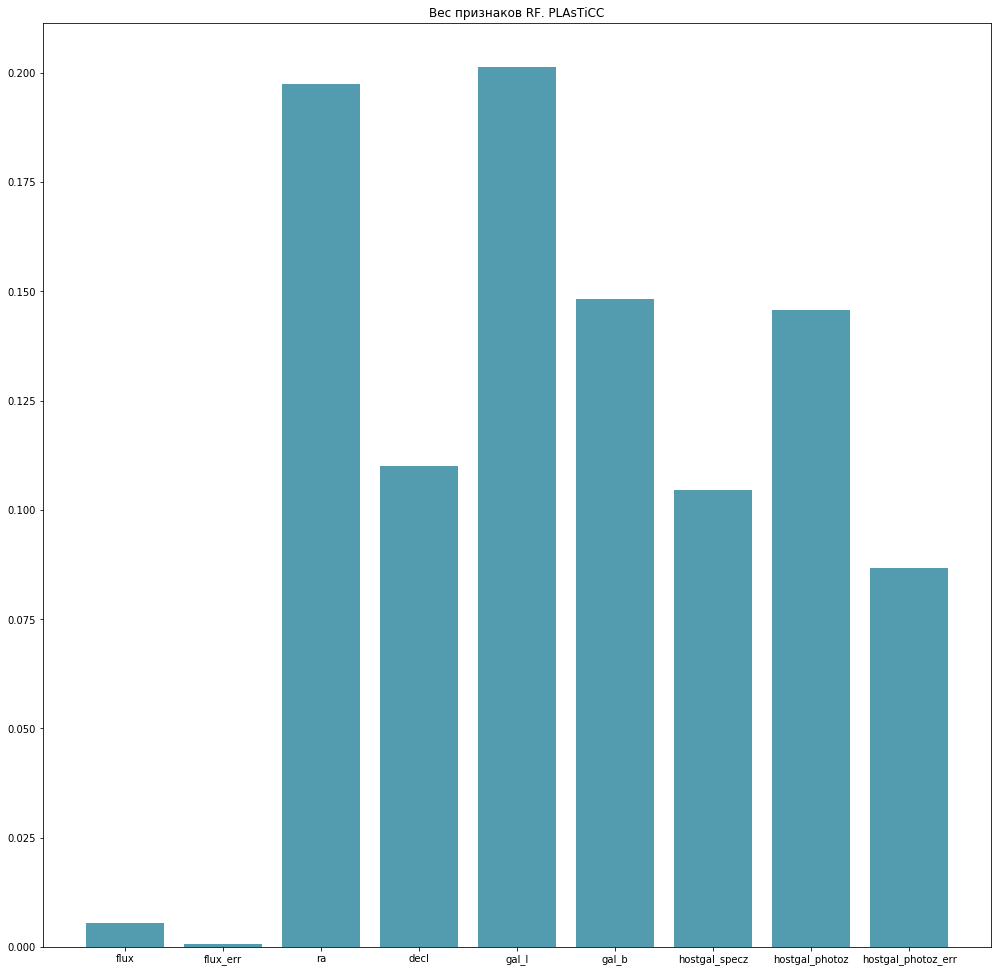

In [39]:
weight_f = rf.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков RF. PLAsTiCC')

Confusion matrix, without normalization


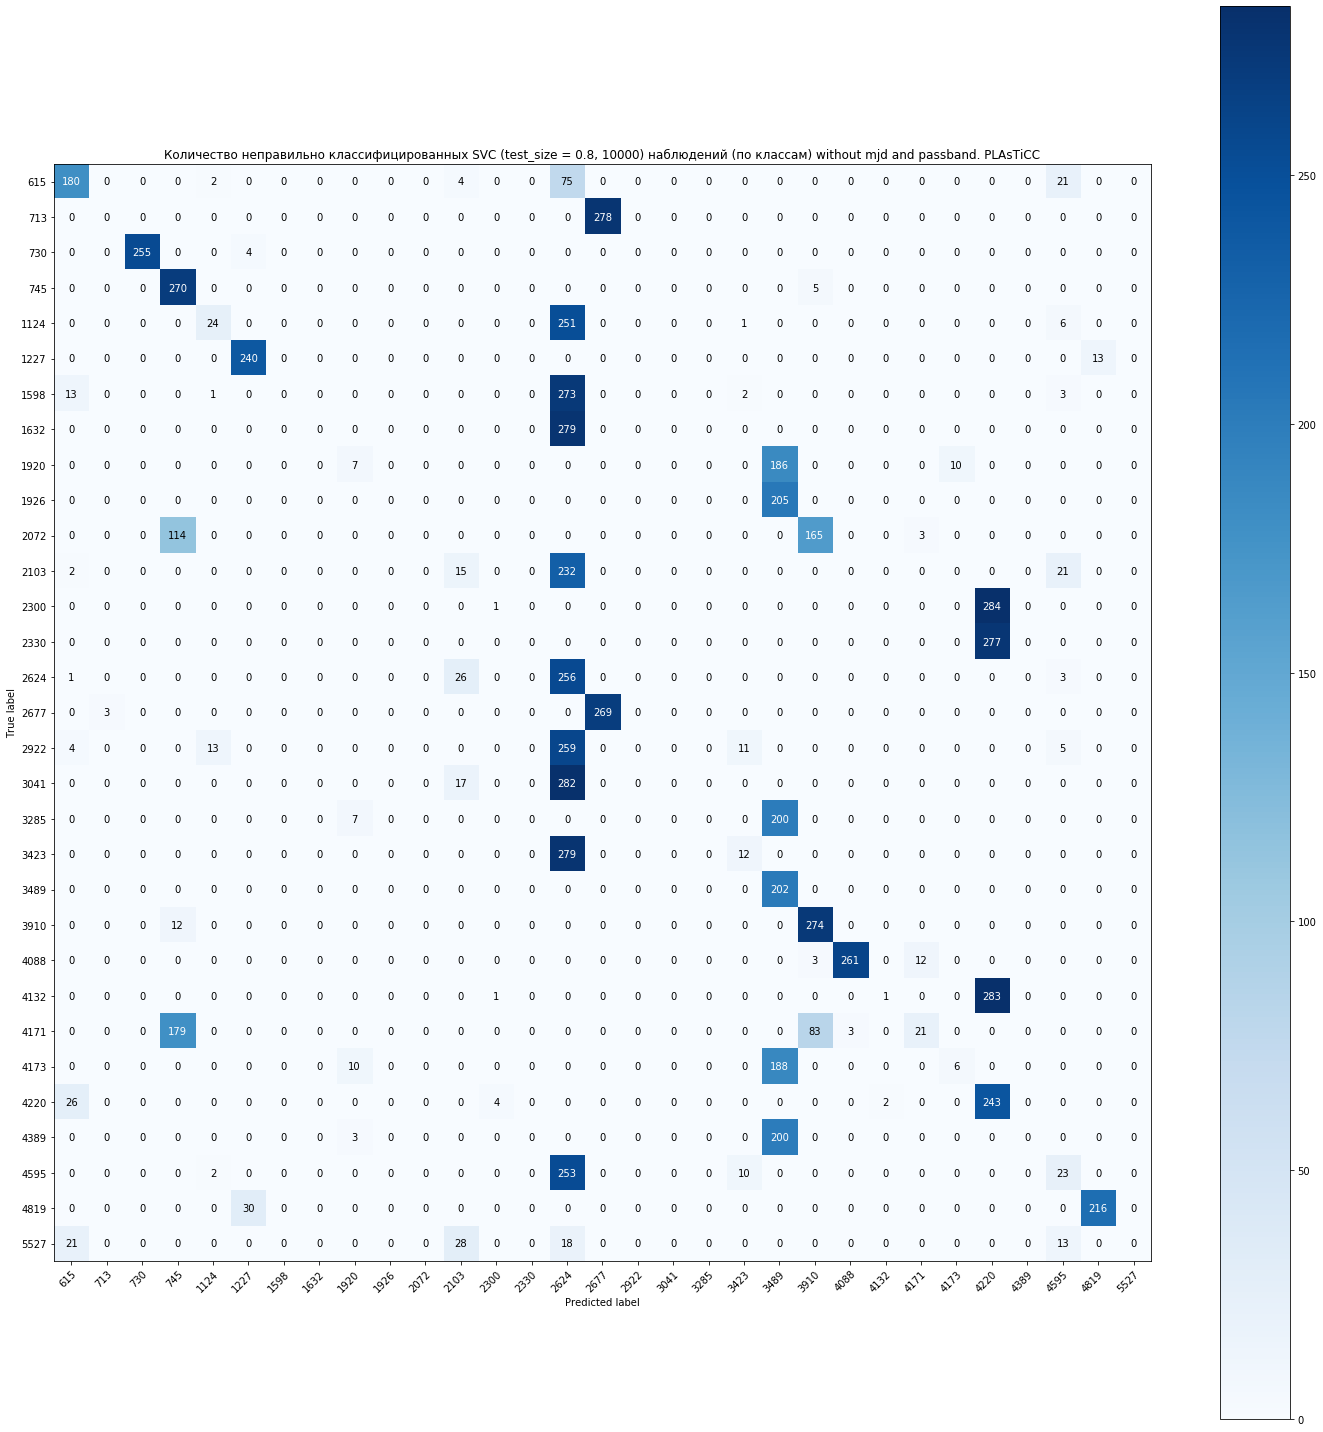

In [41]:
plot_confusion_matrix(y_test, svc_res, x_lab, False, 'Количество неправильно классифицированных SVC (test_size = 0.8, 10000) наблюдений (по классам) without mjd and passband. PLAsTiCC', True)

In [42]:
n = len(y_type.drop_duplicates())
y_test1 = y_type


cluster1 = SpectralClustering(n_clusters = n, random_state = 25, affinity = 'nearest_neighbors', n_neighbors=5)#
cluster1.fit(data)
res = cluster1.labels_


print('accuracy_score: ', accuracy_score(y_test1, res))
print('hamming_loss: ', hamming_loss(y_test1, res))
print('matthews_corrcoef: ', matthews_corrcoef(y_test1, res))
print('precision_score: ', precision_score(y_test1, res, average='macro'))
print('recall_score: ', recall_score(y_test1, res, average='macro'))
print('f1_score: ', f1_score(y_test1, res, average='macro'))

print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))
print()
sp_res = res

C:\Users\админ\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


accuracy_score:  0.0583
hamming_loss:  0.9417
matthews_corrcoef:  0.026929779027770585
precision_score:  0.035195855346310784
recall_score:  0.06168632697332888
f1_score:  0.04383404783621727
completeness_score:  0.8104165173709782
adjusted_rand_score:  0.4065923345336751
v_measure_score:  0.7560024230763801



In [43]:
cluster2 = AgglomerativeClustering(n_clusters = n, affinity = 'euclidean')
cluster2.fit(data)
res = cluster2.labels_

print('accuracy_score: ', accuracy_score(y_test1, res))
print('hamming_loss: ', hamming_loss(y_test1, res))
print('matthews_corrcoef: ', matthews_corrcoef(y_test1, res))
print('precision_score: ', precision_score(y_test1, res, average='macro'))
print('recall_score: ', recall_score(y_test1, res, average='macro'))
print('f1_score: ', f1_score(y_test1, res, average='macro'))
print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))

accuracy_score:  0.0601
hamming_loss:  0.9399
matthews_corrcoef:  0.029222045005481246
precision_score:  0.05522794811329895
recall_score:  0.06269965943463417
f1_score:  0.028090548540845584
completeness_score:  0.8327133891987466
adjusted_rand_score:  0.24791951993552952
v_measure_score:  0.6572266848341282


In [44]:
cluster3 = KMeans(n_clusters= n, init = 'random', n_init=5, max_iter=500)
cluster3.fit(data)
res = cluster3.labels_

print('accuracy_score: ', accuracy_score(y_test1, res))
print('hamming_loss: ', hamming_loss(y_test1, res))
print('matthews_corrcoef: ', matthews_corrcoef(y_test1, res))
print('precision_score: ', precision_score(y_test1, res, average='macro'))
print('recall_score: ', recall_score(y_test1, res, average='macro'))
print('f1_score: ', f1_score(y_test1, res, average='macro'))
print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))

accuracy_score:  0.0332
hamming_loss:  0.9668
matthews_corrcoef:  0.002711619098086551
precision_score:  0.04491791281721763
recall_score:  0.039671381749180605
f1_score:  0.023971964447719284
completeness_score:  0.772812106426873
adjusted_rand_score:  0.24104721829805892
v_measure_score:  0.6435890613690113
